# Importing libraries

In [1]:
import tensorflow as tf

In [1]:
import os
import cv2
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


import tensorflow.keras

import tensorflow

from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout, BatchNormalization, Activation

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score 



In [3]:
#check if GPU enabled or not in tensorflow
import tensorflow
print("Num GPUs Available: ", tensorflow.config.experimental.list_physical_devices('GPU'))

Num GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Defining data paths

In [4]:
train_path = r'D:\Faculty Work\Master\Work\melanoma skin cancer detection\Implementation\DataSet\ISIC2019\data2019v5\training80'
test_path = r'D:\Faculty Work\Master\Work\melanoma skin cancer detection\Implementation\DataSet\ISIC2019\data2019v5\testing10_segmented'
val_path = r'D:\Faculty Work\Master\Work\melanoma skin cancer detection\Implementation\DataSet\ISIC2019\data2019v5\validation10_segmented'

# Converting image to pixels 

melanoma


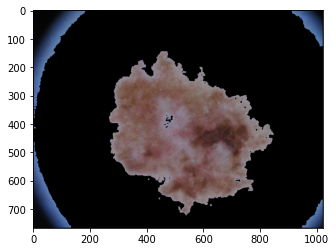

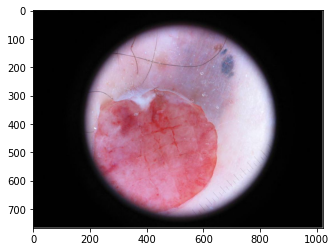

non_melanoma


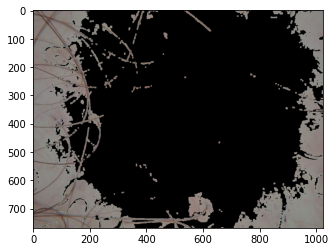

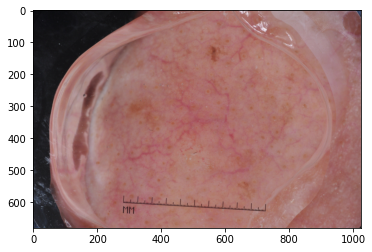

In [5]:
for folder in os.listdir(train_path):
    sub_path = train_path + "/" + folder
    
    print(folder)
    
    image_samples = os.listdir(sub_path)
    
    for i in range(2):
        img = mpimg.imread(sub_path + "/" +image_samples[i])
        imgplot = plt.imshow(img)
        plt.show()

In [6]:

def imagearray(path, size):
    data = []
    for folder in os.listdir(path):
        sub_path=path+"/"+folder

        for img in os.listdir(sub_path):
            image_path=sub_path+"/"+img
            img_arr=cv2.imread(image_path)
            img_arr=cv2.resize(img_arr, size)
            data.append(img_arr)
            
    return data


In [7]:
size = (224,224)

train = imagearray(train_path, size)
test = imagearray(test_path, size)
val = imagearray(val_path, size)

# Normalization

In [8]:
x_train = np.array(train)
x_test = np.array(test)
x_val = np.array(val)

In [9]:
# Just test images dimensions after converting images to numbers in one variable
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)

(5716, 224, 224, 3)
(716, 224, 224, 3)
(714, 224, 224, 3)


In [10]:
x_train = x_train/255.0
x_test = x_test/255.0
x_val = x_val/255.0

In [11]:
#check dimensions after normalization
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)

(5716, 224, 224, 3)
(716, 224, 224, 3)
(714, 224, 224, 3)


# Defining target variables

In [12]:
def data_class(data_path, size, class_mode):
    datagen = ImageDataGenerator(rescale = 1./255)
    classes = datagen.flow_from_directory(data_path,
                                          target_size = size,
                                          batch_size = 32,
                                          class_mode = class_mode)
    return classes

In [13]:
train_class = data_class(train_path, size, 'sparse')
test_class = data_class(test_path, size, 'sparse')
val_class = data_class(val_path, size, 'sparse')

Found 5716 images belonging to 2 classes.
Found 716 images belonging to 2 classes.
Found 714 images belonging to 2 classes.


In [14]:
y_train = train_class.classes
y_test = test_class.classes
y_val = val_class.classes

In [15]:
train_class.class_indices

{'melanoma': 0, 'non_melanoma': 1}

In [16]:
test_class.class_indices

{'melanoma': 0, 'non_melanoma': 1}

In [17]:
y_train.shape,y_test.shape,y_val.shape

((5716,), (716,), (714,))

# VGG19 Model

In [2]:
vgg = VGG19(input_shape = (224, 224, 3), weights = 'imagenet', include_top = False)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [18]:
for layer in vgg.layers:
    layer.trainable = False

x = Flatten()(vgg.output)
prediction = Dense(1, activation='sigmoid')(x)

model = Model(inputs=vgg.input, outputs=prediction)

model.summary()

model.compile(
  loss='binary_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [19]:
plot_model(model=model, show_shapes=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [19]:
early_stop = EarlyStopping(monitor = 'val_loss', mode='min', verbose = 1, patience = 10)

In [20]:
history = model.fit(x_train, y_train, validation_data = (x_val, y_val), epochs = 20, callbacks=[early_stop], batch_size = 32,
                    shuffle=True)

Train on 5716 samples, validate on 714 samples
Epoch 1/20
5716/5716 [==============================] - 637s 111ms/sample - loss: 0.6049 - acc: 0.6912 - val_loss: 0.5903 - val_acc: 0.6975
Epoch 2/20
5716/5716 [==============================] - 605s 106ms/sample - loss: 0.4927 - acc: 0.7547 - val_loss: 0.5634 - val_acc: 0.7381
Epoch 3/20
5716/5716 [==============================] - 602s 105ms/sample - loss: 0.4344 - acc: 0.7918 - val_loss: 0.5841 - val_acc: 0.7199
Epoch 4/20
5716/5716 [==============================] - 601s 105ms/sample - loss: 0.3925 - acc: 0.8254 - val_loss: 0.6650 - val_acc: 0.6933
Epoch 5/20
5716/5716 [==============================] - 601s 105ms/sample - loss: 0.3809 - acc: 0.8270 - val_loss: 0.5377 - val_acc: 0.7605
Epoch 6/20
5716/5716 [==============================] - 601s 105ms/sample - loss: 0.3601 - acc: 0.8376 - val_loss: 0.5596 - val_acc: 0.7507
Epoch 7/20
5716/5716 [==============================] - 600s 105ms/sample - loss: 0.3284 - acc: 0.8607 - val_loss

# Visualization

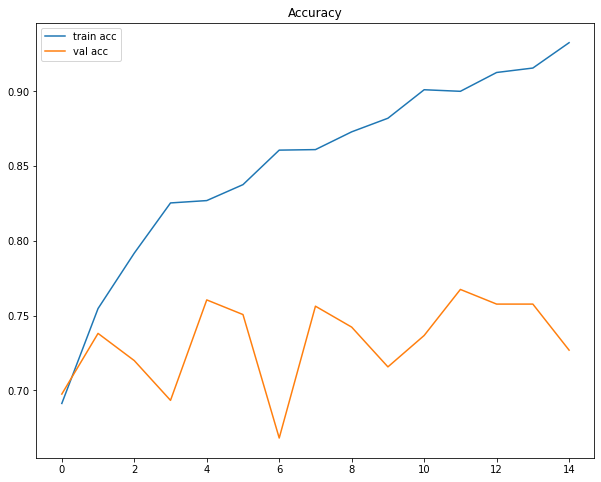

In [21]:
plt.figure(figsize=(10, 8))
plt.plot(history.history['acc'], label='train acc')
plt.plot(history.history['val_acc'], label='val acc')
plt.legend()
plt.title('Accuracy')
plt.show()

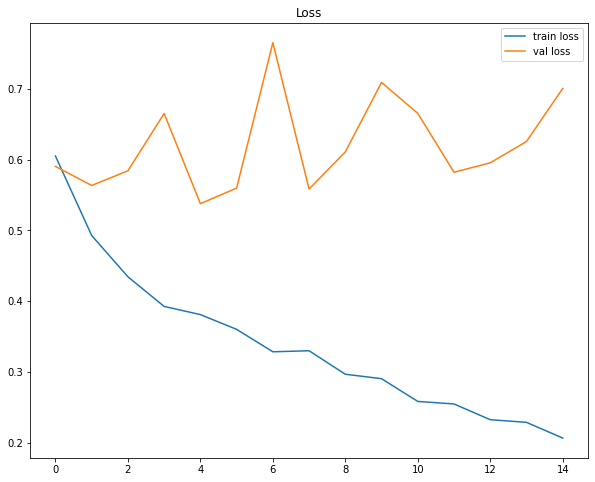

In [22]:
plt.figure(figsize=(10, 8))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss')
plt.show()

# model evaluation

In [23]:
model.evaluate(x_test, y_test, batch_size=32)

716/716 [==============================] - 77s 108ms/sample - loss: 0.5097 - acc: 0.7765


[0.5097313286871884, 0.7765363]

# Confusion Matrix

In [24]:
y_pred = model.predict(x_test)

In [ ]:
print(type(y_test))

print(np.shape(y_test))

print(y_test)

In [ ]:
print(type(y_pred))

print(np.shape(y_pred))

print(y_pred[0])

In [25]:
#thresholding results of y_pred in >=0.5  make it 1 otherwise 0 (Binary Classification)

for i in range(0,716):
    if (y_pred[i]>=0.5):
        y_pred[i]=1
    else:
        y_pred[i]=0



#multiclassification problems
#y_pred=np.argmax(y_pred,axis=1)

In [ ]:
print(y_pred)

In [26]:
#multiclassification problems
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

         0.0       0.91      0.72      0.80       454
         1.0       0.64      0.88      0.74       262

    accuracy                           0.78       716
   macro avg       0.78      0.80      0.77       716
weighted avg       0.81      0.78      0.78       716



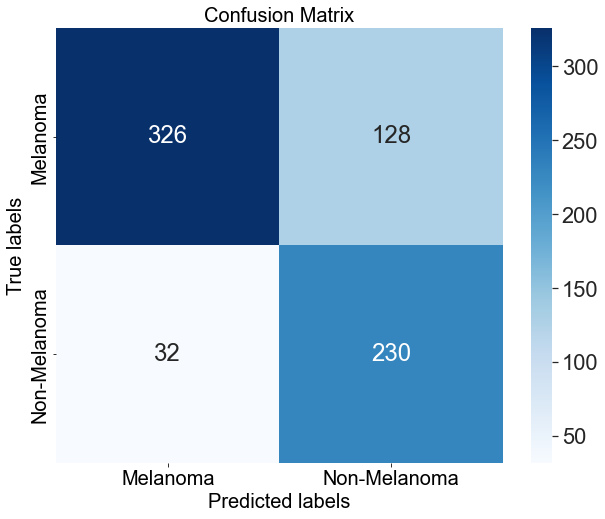

In [27]:
cm = confusion_matrix(y_pred,y_test)

plt.figure(figsize=(10, 8))
ax = plt.subplot()
sns.set(font_scale=2.0)
sns.heatmap(cm, annot=True, fmt='g', cmap="Blues", ax=ax); 

# labels, title and ticks
ax.set_xlabel('Predicted labels', fontsize=20);ax.set_ylabel('True labels', fontsize=20); 
ax.set_title('Confusion Matrix', fontsize=20); 
ax.xaxis.set_ticklabels(['Melanoma', 'Non-Melanoma'], fontsize=20); ax.yaxis.set_ticklabels(['Melanoma', 'Non-Melanoma'], fontsize=20);


In [28]:
f1_score(y_test, y_pred)

0.7419354838709677

In [29]:
recall_score(y_test, y_pred)

0.6424581005586593

In [30]:
precision_score(y_test, y_pred)

0.8778625954198473

# saving model

In [31]:
model.save("test.h5")

# upload mode

In [2]:
uploaded_model = tf.keras.models.load_model('test.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [18]:
uploaded_model.evaluate(x_test, y_test, batch_size=32)

716/716 [==============================] - 91s 127ms/sample - loss: 0.4579 - acc: 0.7905


[0.45788316253843253, 0.7905028]

In [20]:
y_pred = uploaded_model.predict(x_test)

In [21]:
#thresholding results of y_pred in >=0.5  make it 1 otherwise 0 (Binary Classification)

for i in range(0,716):
    if (y_pred[i]>=0.5):
        y_pred[i]=1
    else:
        y_pred[i]=0


In [22]:
#multiclassification problems
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

         0.0       0.87      0.75      0.81       418
         1.0       0.71      0.85      0.77       298

    accuracy                           0.79       716
   macro avg       0.79      0.80      0.79       716
weighted avg       0.80      0.79      0.79       716



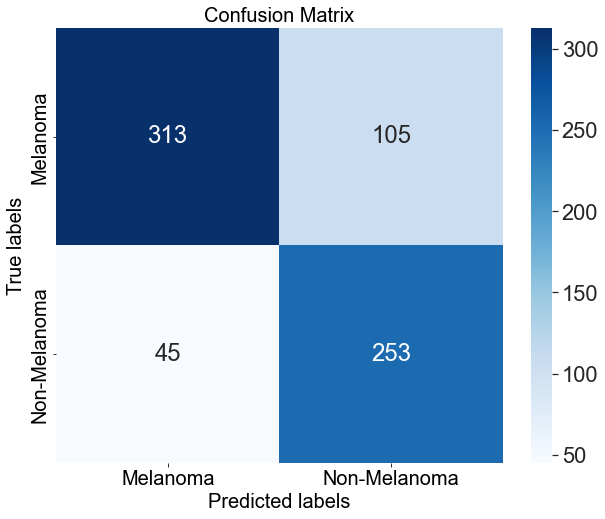

In [23]:
cm = confusion_matrix(y_pred,y_test)

plt.figure(figsize=(10, 8))
ax = plt.subplot()
sns.set(font_scale=2.0)
sns.heatmap(cm, annot=True, fmt='g', cmap="Blues", ax=ax); 

# labels, title and ticks
ax.set_xlabel('Predicted labels', fontsize=20);ax.set_ylabel('True labels', fontsize=20); 
ax.set_title('Confusion Matrix', fontsize=20); 
ax.xaxis.set_ticklabels(['Melanoma', 'Non-Melanoma'], fontsize=20); ax.yaxis.set_ticklabels(['Melanoma', 'Non-Melanoma'], fontsize=20);


In [24]:
f1_score(y_test, y_pred)

0.7713414634146342

In [25]:
recall_score(y_test, y_pred)

0.7067039106145251

In [26]:
precision_score(y_test, y_pred)

0.8489932885906041